In [1]:
#============软间隔支持向量机============
#约束条件是
#y * (w * x + b) >= 1 - xi
#因为是软间隔,所以不可能所有的点都满足>=1的约束,所以引入了松弛变量xi

#优化目标函数是
#最小化 -> w平方后求和再开方(2范数)/2 + C*(xi求和)
#这里C>0,称为惩罚参数
#优化目标函数包含两层含义,1.使w的2范数尽量小,2.使误分类的点的个数尽量少,C是二者的调和系数

#综合以上,把学习目标写为如下:
#优化目标函数:
#最小化 -> w平方后求和再开方(2范数)/2 + C*(xi求和)
#约束条件:
#y * (w * x + b) >= 1 - xi
#xi >= 0
#分离超平面:
#w * x + b = 0
#分类决策函数:
#sign(w * x + b)

#书上并没有直接解上面的问题,而是转换为了对偶问题来解
#优化目标函数:
#最小化 -> 1/2 * sigma i=1 -> N sigma j=1 -> N alpha_i * alpha_j * y_i * y_j * (x_i · x_j) - (alpha求和)
#写为伪代码:
"""
_sum = 0
for i in range(N):
    for j in range(N):
        _sum += alpha[i] * alpha[j] * Y[i] * Y[j] * np.dot(X[i], X[j])
_sum /= 2
_sum -= alpha.sum()"""
#约束条件:
#求和(alpha * y) = 0
#0 <= alpha <= C
#解出这个方程以后,就可以算出w和b了
#w = 求和(alpha * y * x)
#b = y_j - 求和(y * alpha * (x_i · x_j))
#这里的j是大于0小于C的alpha的下标,i是求和(sigma)的遍历符号,也就是说会求出多个b,可能并不相同,所以b不是唯一的

#============核函数支持向量机============
#优化目标函数,其实就是把上面的优化目标函数里的(x_i · x_j)替换为K(x_i,x_j):
#最小化 -> 1/2 * sigma i=1 -> N sigma j=1 -> N alpha_i * alpha_j * y_i * y_j * K(x_i,x_j) - (alpha求和)
#写为伪代码:
"""
#其实就是把上面的伪代码里的np.dot(X[i], X[j])改为K(X[i], X[j])
_sum = 0
for i in range(N):
    for j in range(N):
        _sum += alpha[i] * alpha[j] * Y[i] * Y[j] * K(X[i], X[j])
_sum /= 2
_sum -= alpha.sum()"""
#书上没有提到约束条件, 是没有了还是和原来保持一致? 不清楚.
#分类决策函数:
#sigma i=1 -> N [alpha_i * y_i * K(x,x_i)] + b

#解释下什么是K函数,phi函数是把x转换到另一个空间的函数
#K(x_i,x_j) = phi(x_i) · phi(x_j)

#============SMO支持向量机============
#假设只优化alpha_0和alpha_1,其他的alpha固定
#优化目标函数:
#略,太长了
#写为伪代码:
"""
_sum = 0
#这里的Y[0] * Y[0]其实没有必要,因为一定是1
_sum += Y[0] * Y[0] * K(X[0], X[0]) * alpha[0] * alpha[0] / 2
#这里的Y[1] * Y[1]其实没有必要,因为一定是1
_sum += Y[1] * Y[1] * K(X[1], X[1]) * alpha[1] * alpha[1] / 2
_sum += Y[0] * Y[1] * K(X[0], X[1]) * alpha[0] * alpha[1] - alpha[0] - alpha[1]

s1 = 0
for i in range(2, N):
    s1 += Y[i] * alpha[i] * K(X[i], X[0])

s2 = 0
for i in range(2, N):
    s2 += Y[i] * alpha[i] * K(X[i], X[1])

_sum += Y[0] * alpha[0] * s1
_sum += Y[1] * alpha[1] * s1
_sum"""
#约束条件:
#alpha_0 * y_0 + alpha_1 * y_1 = 0 - sigma i=2->N y_i * alpha_i
#0 <= alpha <= C
#虽然有alpha_0和alpha_1两个变量,但自由度只有1,一个变量确定时,另一个也就确定了.所以只需要计算出一个的值.
#这里假设我们只考虑优化alpha_1
#alpha_1的取值范围是 L <= alpha_1 <= H
#如果y_0 != y_1,则L = max(0,alpha_1 - alpha_0),H = min(C,C + alpha_1 - alpha_0)
#如果y_0 == y_1,则L = max(0,alpha_1 + alpha_0 - C),H = min(C,alpha_1 + alpha_0)

#为了叙述简单,定义函数g
#g(x) = sigma i=0 -> N[alpha_i * y_i * K(x_i,x)] + b
#E就是g函数的预测和真实y之间的差
#E_i = g(x_i) - y_i, i=0,1
#训练算法:
#alpha_1 = alpha_1 + {y_1 * (E_0 - E_1) / [K(x_0,x_0) + K(x_1,x_1) - 2 * K(x_0,x_1)]}
#alpha_1 = H if alpha_1 > H
#alpha_1 = L if alpha_1 < H
#再计算alpha_0:
#alpha_0 = alpha_0 + y_0 * y_1 * (alpha_1_old - alpha_1_new)

#变量的选择:
#首先要找到一个违反kkt条件最严重的alpha,记为alpha_0
#kkt条件:
#if alpha = 0 then y * g(x) >= 1
#if alpha = C then y * g(x) <= 1
#if 0 < alpha < C then y * g(x) == 1
#第二个变量要找一个能使|E_0 - E_1|最大的alpha,记为alpha_1

#每次优化完两个alpha后,要重新计算b,因为更新了两个alpha,所以会得出两个b
#b1 = 0 - E_0 - y_0 * K(0,0) * (alpha_new_0 - alpha[0]) - y_1 * K(1,0) * (alpha_new_1 - alpha[1]) + b
#b1 = 0 - E_1 - y_0 * K(0,1) * (alpha_new_0 - alpha[0]) - y_1 * K(1,1) * (alpha_new_1 - alpha[1]) + b
#如果alpha_new_0,alpha_new_1同时满足 0 < alpha < C 那么b1==b2
#如果alpha_new_0,alpha_new_1是0或者C,那么b1到b2都符号kkt条件,选择他们的中点作为新的b

'\n_sum = 0\n#这里的Y[0] * Y[0]其实没有必要,因为一定是1\n_sum += Y[0] * Y[0] * K(X[0], X[0]) * alpha[0] * alpha[0] / 2\n#这里的Y[1] * Y[1]其实没有必要,因为一定是1\n_sum += Y[1] * Y[1] * K(X[1], X[1]) * alpha[1] * alpha[1] / 2\n_sum += Y[0] * Y[1] * K(X[0], X[1]) * alpha[0] * alpha[1] - alpha[0] - alpha[1]\n\ns1 = 0\nfor i in range(2, N):\n    s1 += Y[i] * alpha[i] * K(X[i], X[0])\n\ns2 = 0\nfor i in range(2, N):\n    s2 += Y[i] * alpha[i] * K(X[i], X[1])\n\n_sum += Y[0] * alpha[0] * s1\n_sum += Y[1] * alpha[1] * s1\n_sum'

In [2]:
import numpy as np
import random


#加载数据
def load_data(file_name):
    N = 100
    
    #可分不可分都可以处理
    with open(file_name) as fr:
        lines = fr.readlines()

    x = np.ones((N, 28 * 28), dtype=float)
    y = np.empty(N, dtype=int)

    #就加载100个数据,太多了算不动
    for i in range(N):
        line = lines[i].strip().split(',')
        x[i] = line[1:]
        y[i] = line[0]

    #压缩到0-1之间
    x /= 255

    #如果是0,y就是1,否则就是-1
    y[y != 0] = -1
    y[y == 0] = 1

    return x, y


X, Y = load_data('./mnist_train.csv')
X[:5], Y[:5]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1,  1, -1, -1, -1]))

In [3]:
#定义常量
N, M = X.shape

C = 200  #惩罚参数,C值越大时,对误分类的惩罚越大

alpha = np.zeros(N)  #拉格朗日乘子
b = 0.0

In [4]:
#这个函数就是高斯核函数
def K(i, j):
    #l2 = ((X[i] - X[j])**2).sum()**0.5
    l2 = np.linalg.norm(X[i] - X[j], ord=2)

    return np.exp(-l2 / 200)


K(0, 1)

0.9542724028981369

In [5]:
#g(x) = sigma i=0 -> N[alpha_i * y_i * K(x_i,x)] + b
#预测函数
def g(i):
    _sum = 0
    for j in range(N):
        _sum += alpha[j] * Y[j] * K(i, j)
    _sum += b
    return _sum


g(0)

0.0

In [6]:
#E = g(x) - y
#误差函数
def E(i):
    return g(i) - Y[i]


E(0)

1.0

In [7]:
#kkt条件:
#if alpha = 0 then y * g(x) >= 1
#if alpha = C then y * g(x) <= 1
#if 0 < alpha < C then y * g(x) == 1
def kkt(i):
    if alpha[i] == 0:
        return Y[i] * g(i) >= 1
    if alpha[i] == C:
        return Y[i] * g(i) <= 1
    if 0 < alpha[i] < C:
        return Y[i] * g(i) == 1
    return False


def get_kkt_difference(i):
    if kkt(i):
        return 0

    if alpha[i] == 0:
        return 1 - Y[i] * g(i)
    if alpha[i] == C:
        return Y[i] * g(i) - 1
    if 0 < alpha[i] < C:
        return np.abs(1 - Y[i] * g(i))
    return 100


kkt(0), get_kkt_difference(0)

(False, 1.0)

In [8]:
def pick_idx():
    #首先要找到一个违反kkt条件最严重的
    max_kkt_difference = 0
    _i = -1
    for i in range(N):
        if kkt(i):
            continue

        kkt_difference = get_kkt_difference(i)
        if max_kkt_difference >= kkt_difference:
            continue

        max_kkt_difference = kkt_difference
        _i = i

    #第二个变量要找一个能使|E_0 - E_1|最大的
    max_E_difference = 0
    _j = -1
    for i in range(N):
        E_difference = np.abs(E(_i) - E(i))
        if max_E_difference >= E_difference:
            continue

        max_E_difference = E_difference
        _j = i

    return _i, _j


pick_idx()

(0, 1)

In [9]:
#如果y_0 != y_1,则L = max(0,alpha_1 - alpha_0),H = min(C,C + alpha_1 - alpha_0)
#如果y_0 == y_1,则L = max(0,alpha_1 + alpha_0 - C),H = min(C,alpha_1 + alpha_0)
def get_L_and_H(i, j):
    L, H = 0, 0

    if Y[i] != Y[j]:
        L = max(0, alpha[j] - alpha[i])
        H = min(C, C + alpha[j] - alpha[i])
    else:
        L = max(0, alpha[j] + alpha[i] - C)
        H = min(C, alpha[j] + alpha[i])

    return L, H


get_L_and_H(0, 1)

(0, 200)

In [10]:
def get_b(i, j, alpha_new_i, alpha_new_j):
    #b1 = 0 - E_0 - y_0 * K(0,0) * (alpha_new_0 - alpha[0]) - y_1 * K(1,0) * (alpha_new_1 - alpha[1]) + b
    #b1 = 0 - E_1 - y_0 * K(0,1) * (alpha_new_0 - alpha[0]) - y_1 * K(1,1) * (alpha_new_1 - alpha[1]) + b
    b1 = 0 - E(i) - Y[i] * K(i, i) * (alpha_new_i - alpha[i]) - Y[j] * K(
        j, i) * (alpha_new_j - alpha[j]) + b
    b2 = 0 - E(j) - Y[i] * K(i, j) * (alpha_new_i - alpha[i]) - Y[j] * K(
        j, j) * (alpha_new_j - alpha[j]) + b

    #如果alpha_new_0,alpha_new_1同时满足 0 < alpha < C 那么b1==b2
    if 0 < alpha_new_i < C and 0 < alpha_new_j < C:
        #print('b1==b2 = ', b1 == b2)
        return b1

    #如果alpha_new_0,alpha_new_1是0或者C,那么b1到b2都符号kkt条件,选择他们的中点作为新的b
    return (b1 + b2) / 2


get_b(0, 1, 1, 1)

-0.9542724028981369

In [11]:
#训练算法
def get_new_alpha(i, j, L, H):
    #再计算alpha_1:
    #alpha_1 = alpha_1 + {y_1 * (E_0 - E_1) / [K(x_0,x_0) + K(x_1,x_1) - 2 * K(x_0,x_1)]}
    alpha_new_j = alpha[j] + Y[j] * (E(i) - E(j)) / (K(i, i) + K(j, j) -
                                                     2 * K(i, j))

    #alpha_1 = H if alpha_1 > H
    #alpha_1 = L if alpha_1 < H
    if alpha_new_j > H:
        alpha_new_j = H
    if alpha_new_j < L:
        alpha_new_j = L

    #再计算alpha_0:
    #alpha_0 = alpha_0 + y_0 * y_1 * (alpha_1_old - alpha_1_new)
    alpha_new_i = alpha[i] + Y[i] * Y[j] * (alpha[j] - alpha_new_j)

    return alpha_new_i, alpha_new_j


get_new_alpha(0, 1, 1, 100)

(21.868632147287173, 21.868632147287173)

In [12]:
def train():
    global alpha
    global b

    iterStep = 0  #迭代次数

    #判断收敛或者迭代次数达到上限
    while (iterStep < 5):
        iterStep += 1

        #找到本次要优化的两个alpha
        i, j = pick_idx()

        L, H = get_L_and_H(i, j)

        #训练新的2个alpha
        alpha_new_i, alpha_new_j = get_new_alpha(i, j, L, H)

        #训练新的b
        b = get_b(i, j, alpha_new_i, alpha_new_j)

        #更新参数
        alpha[i] = alpha_new_i
        alpha[j] = alpha_new_j


train()

In [13]:
#测试
def K_for_test(x1, x2):
    difference = x1 - x2
    l2 = np.linalg.norm(difference, ord=2)
    return np.exp(-l2 / 200)

def predict_for_test(x1):
    _sum = 0
    for i in range(N):
        _sum += alpha[i] * Y[i] * K_for_test(x1, X[i])
    _sum += b
    return _sum


test_X, test_Y = load_data('./mnist_test.csv')


correct = 0
for i in range(N):
    pred = predict_for_test(test_X[i])
    pred = 1 if pred > 0 else -1
    if pred == test_Y[i]:
        correct += 1

print('accuracy=', correct / N)

accuracy= 0.98


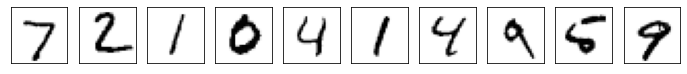

     -         -         -         0         -         -         -         -         -         -    


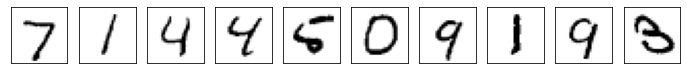

     -         -         -         -         -         0         -         -         -         -    


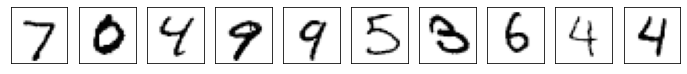

     -         0         -         -         -         -         -         -         -         -    


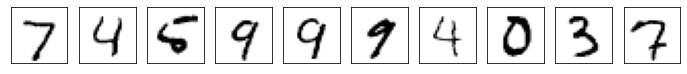

     -         -         -         -         -         -         -         0         -         -    


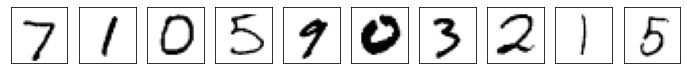

     -         -         0         -         -         0         -         -         -         -    


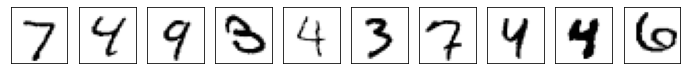

     -         -         -         -         -         -         -         -         -         -    


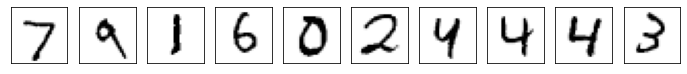

     -         -         -         -         0         -         -         -         -         -    


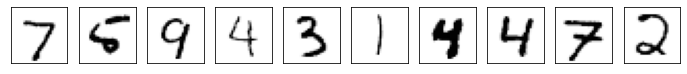

     -         -         -         -         -         -         -         -         -         -    


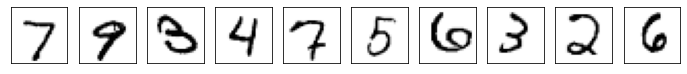

     -         -         -         -         -         -         -         -         -         -    


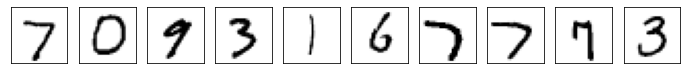

     -         0         -         -         -         -         -         -         -         -    


In [14]:
import matplotlib.pyplot as plt

for i in range(10):

    _, ax = plt.subplots(figsize=(12, 12),
                         nrows=1,
                         ncols=10,
                         sharex='all',
                         sharey='all')

    print_line = ''

    for j in range(10):
        idx = (i + 1) * j

        ax[j].imshow(test_X[idx].reshape(28, 28), cmap='Greys')

        pred = predict_for_test(test_X[idx])
        pred = '0' if pred > 0 else '-'

        print_line += '     ' + pred + '    '

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.show()

    print(print_line)